# JOB-A-THON April 2022


In [1]:
import pandas as pd

In [2]:
#insert path of training data in sv format
train_data = pd.read_csv('/content/train_E1GspfA.csv')
train_data.shape

(18247, 3)

The training dataset contains of 18247 data points. 
The data is made up of 3 dimensions namely:-


1.   Date
2.   Hour
3. Demand



  





In [3]:
train_data.head(7)

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81
5,2018-08-18,16,37
6,2018-08-18,17,27


In [4]:
#convertind date to pandas datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

Date Range of training data

In [5]:
print(f"initial date : {str(train_data['date'].dt.date.min())}")
print(f"final date : {str(train_data['date'].dt.date.max())}")

initial date : 2018-08-18
final date : 2021-02-28


In the given data, hour and date are two separate columns which is not necessary so we can combine date and hour as one column

In [6]:
def Combine_date_hour(dataFrame):
    dataFrame['date'] = pd.to_datetime(dataFrame['date']) + dataFrame['hour'].astype('timedelta64[h]')
    dataFrame.drop(columns=['hour'], axis=1, inplace=True)
    return dataFrame

Removing the 'hour' column since it has been combined with date column

In [7]:
train_data = Combine_date_hour(train_data)
train_data.head(7)

,date,demand
0,2018-08-18 09:00:00,91
1,2018-08-18 10:00:00,21
2,2018-08-18 13:00:00,23
3,2018-08-18 14:00:00,104
4,2018-08-18 15:00:00,81
5,2018-08-18 16:00:00,37
6,2018-08-18 17:00:00,27


In [8]:
train_data

,date,demand
0,2018-08-18 09:00:00,91
1,2018-08-18 10:00:00,21
2,2018-08-18 13:00:00,23
3,2018-08-18 14:00:00,104
4,2018-08-18 15:00:00,81
...,...,...
18242,2021-02-28 19:00:00,95
18243,2021-02-28 20:00:00,88
18244,2021-02-28 21:00:00,39
18245,2021-02-28 22:00:00,104


# Exploratory Data Analysis

In [9]:
import plotly.express as px

In [10]:
fig = px.line(train_data, x='date', y='demand')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

# splitting training data in tain and validation set

In [11]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [12]:
train_data.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)
training_data = train_data.sample(frac=0.8, random_state=10)

val_data = train_data.drop(training_data.index)

print(f'training data size : {training_data.shape}')
print(f'validation data size : {val_data.shape}')


training data size : (14598, 2)
validation data size : (3649, 2)


# Prediction Models

importing required libraries

In [13]:
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet

fitting the model on the training data

Performing prediction on the validation dataset

In [14]:
import numpy as np

In [15]:
model = Prophet(changepoint_prior_scale=0.49, seasonality_prior_scale = 0.21)
model.fit(training_data)
prediction = model.predict(pd.DataFrame({'ds':val_data['ds']}))
y_actual = np.array(val_data['y'])
y_predicted = prediction['yhat']
y_predicted = y_predicted.astype(int)
print('RMSE :- ', mean_squared_error(y_actual, y_predicted, squared=False))

RMSE :-  36.51762395629729


In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=val_data['ds'], y=y_actual, name="Actual Data"),
    secondary_y=False)

fig.add_trace(go.Scatter(x=val_data['ds'], y=y_predicted, name="Predicted Data"),
    secondary_y=True)

fig.update_layout(
    title_text="Actual vs Predicted Data"
)

fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="<b>Actual</b> Data", secondary_y=False)
fig.update_yaxes(title_text="<b>Predicted</b> Data", secondary_y=True)

fig.show()

# Predictions on test dataset

In [17]:
test_data = pd.read_csv('/content/test_6QvDdzb.csv')
print(f'test dataset size : {test_data.shape}')
testing_data = Combine_date_hour(test_data.copy())
testing_data.head()

test dataset size : (7650, 2)


,date
0,2021-03-01 00:00:00
1,2021-03-01 01:00:00
2,2021-03-01 02:00:00
3,2021-03-01 03:00:00
4,2021-03-01 05:00:00


In [18]:
prediction_test_set = model.predict(pd.DataFrame({'ds':testing_data['date']}))

In [19]:
prediction_test_set = prediction_test_set['yhat']
prediction_test_set = prediction_test_set.astype(int)
test_data['demand'] = prediction_test_set
test_data.head()
test_data.to_csv('submission.csv', index=False)

#VISUALIZATION TRENDS

In [20]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-09-01 22:00:00 and 2020-09-01 22:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-01 23:00:00,48.909976,3.388348,95.858778,35,2020-09-01 22:00:00
1,2020-09-02 02:00:00,39.971090,-7.360738,85.606401,61,2020-09-01 22:00:00
2,2020-09-02 04:00:00,36.982929,-8.875238,81.951076,75,2020-09-01 22:00:00
3,2020-09-02 05:00:00,38.619642,-8.869083,84.480145,40,2020-09-01 22:00:00
4,2020-09-02 06:00:00,42.188221,-3.740523,89.789895,50,2020-09-01 22:00:00


In [21]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,16 days 04:00:00,1561.929797,39.521258,31.677869,0.724893,0.388686,0.776062
1,16 days 08:00:00,1561.215966,39.512226,31.635488,0.723610,0.387846,0.776062
2,16 days 09:00:00,1566.938414,39.584573,31.723667,0.724025,0.388686,0.776062
3,16 days 10:00:00,1570.635926,39.631249,31.766149,0.723820,0.388686,0.772201
4,16 days 11:00:00,1571.170700,39.637996,31.806570,0.724281,0.388686,0.772201


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



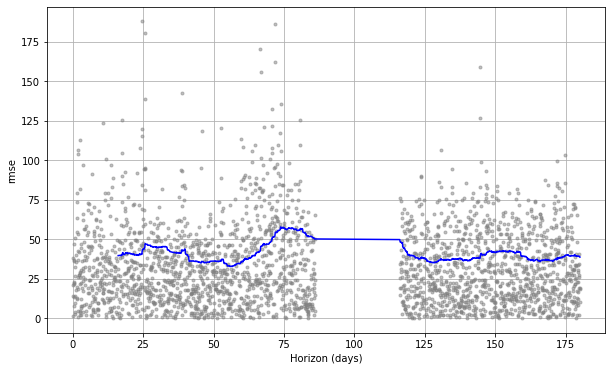

In [22]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')
